In [1]:
with open('DebrisFlow.txt') as f:
    lines = f.readlines()
    
X= []
Y= []
for line in lines:
    a = str.split(line)
    a[0] = float(a[0])
    a[1] = float(a[1])
    X.append(a[0])
    Y.append(a[1])

X= X[:16]
Y= Y[:16]
import pyomo.environ as pyo
model= pyo.ConcreteModel()

I = [i for i in range(len(X))]
model.Iset= pyo.Set(initialize= I)

def X_(model, i):
    return X[i]
model.X= pyo.Param(model.Iset, rule= X_)

def Y_(model, i):
    return Y[i]
model.Y= pyo.Param(model.Iset, rule= Y_)

# Clusterning Params and Vars 

In [2]:
B = [0,1,2]
model.Bset= pyo.Set(initialize= B)

In [3]:
model.dist= pyo.Var(model.Iset, domain= pyo.NonNegativeReals)

In [4]:
model.delta= pyo.Var(model.Iset, model.Bset, domain= pyo.Binary)

In [5]:
M= [6.5 for y in Y]
def M_(model,i):
    return M[i]
model.M= pyo.Param(model.Iset, rule= M_)

In [6]:
model.c = pyo.Var(model.Bset, domain=pyo.NonNegativeReals)
model.d = pyo.Var(model.Bset, domain=pyo.Reals)

Constraints

In [7]:
def const_1(model, i, b):
    return model.Y[i]-(model.c[b]*model.X[i] + model.d[b])<= model.dist[i]+ model.M[i]*(1-model.delta[i,b])
model.const_1= pyo.Constraint(model.Iset, model.Bset, rule= const_1)

In [8]:
def const_2(model, i, b):
    return (model.c[b]*model.X[i] + model.d[b])- model.Y[i]<= model.dist[i]+ model.M[i]*(1-model.delta[i,b])
model.const_2= pyo.Constraint(model.Iset, model.Bset, rule= const_2)

In [9]:
def delta_(model, i):
    return sum(model.delta[i,b] for b in model.Bset)==1
model.const_delta= pyo.Constraint(model.Iset, rule=delta_)

Objective

In [10]:
def obj(model):
    return sum(model.dist[i] for i in model.Iset)
model.obj= pyo.Objective(rule=obj, sense= pyo.minimize)

Solve and Result

In [11]:
opt = pyo.SolverFactory('glpk') 
result=opt.solve(model,'glpk')

In [12]:
print(pyo.value(model.obj))

0.3180976143844104


# Visualization

In [13]:
delta_results= [pyo.value(model.delta[i,b]) for i in model.Iset for b in model.Bset]

In [14]:
dist_results= [pyo.value(model.dist[i]) for i in model.Iset]
print(max(dist_results))

0.174268727634621


In [15]:
Cluster= {}
for b in model.Bset:
    Cluster[b]= {}
    Cluster[b]['X']= []
    Cluster[b]['Y']= []
for b in model.Bset:
    for i in model.Iset:
        if pyo.value(model.delta[i, b]) == 1:
            Cluster[b]['X'].append(model.X[i])
            Cluster[b]['Y'].append(model.Y[i])

In [16]:
C= {}
D= {}
for b in model.Bset:
    C[b]= pyo.value(model.c[b])
    D[b]= pyo.value(model.d[b])

In [17]:
c_results= [pyo.value(model.c[b]) for b in model.Bset]
d_results= [pyo.value(model.d[b]) for b in model.Bset]

In [18]:
print(c_results)

[7.41775237273532e-05, 0.0281227307567859, 0.0538484233839074]


In [19]:
print(round(max(c_results)-min(c_results),3))
print(round(max(d_results)-min(d_results),3))

0.054
3.453


In [20]:
import matplotlib.pyplot as plt

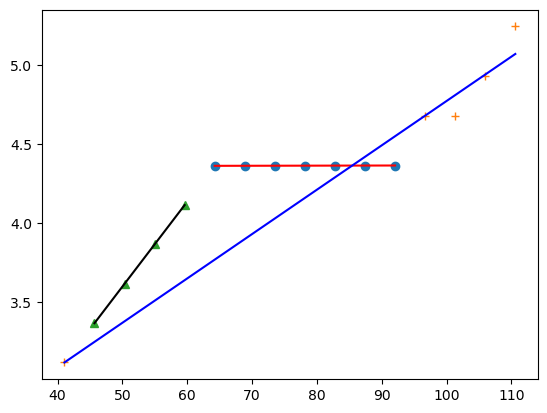

In [21]:
shape= ['o','+','^','*']
color= ['r','b','k','g']
count= 0
for b in model.Bset:
    S= shape[count]+':'+color[count]
    plt.plot(Cluster[b]['X'], Cluster[b]['Y'], shape[count])
    plt.plot(Cluster[b]['X'], [x*C[b]+D[b] for x in Cluster[b]['X']],color[count])
    count+= 1
    
plt.show()